In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2-D model

State space is square [-1,1] x [-1,1]. Actions are 'right'=0, 'left'=1,'up'=2,'down'=3

In [8]:
# Defining continuous model

actions=['right','left','up','down']

cost_param_a=2.0 # weight for the state dependent cost factor
cost_param_b=0.6 # weight for the action dependent cost factor
distr_param_offset=0.3
distr_param_v=0.003

def nextState(s,a):
    "Sampling successor given concrete state"
    snew=s.copy()
    noise=np.random.multivariate_normal([0,0],[[distr_param_v,0],[0,distr_param_v]])
    if a==0:
        snew+=np.array([distr_param_offset,0])
    if a==1:
        snew+=np.array([-distr_param_offset,0])
    if a==2:
        snew+=np.array([0,distr_param_offset])
    if a==3:
        snew+=np.array([0,-distr_param_offset])
    snew+=noise    
    snew[0]=np.max((-1,np.min((1,snew[0]))))
    snew[1]=np.max((-1,np.min((1,snew[1]))))
    return snew


def cost(s,a):
    # cost of state: center is good!
    c=cost_param_a*(s[0]**2+s[1]**2)
    # cost of actions: More expensive when less likely to bump into border:
    if a==0:
        return c+cost_param_b*(1-s[0])
    if a==1:
        return c+cost_param_b*(1+s[0])
    if a==2:
        return c+cost_param_b*(1-s[1])
    if a==3:
        return c+cost_param_b*(1+s[1])
    return c
    


# def cost_region(corners,a):
#     """
#     average cost of region given by integral of cost(s,a) values
    
#     Region given by its 4 corners. 
#     """
#     # cost from state component:
#     c=(cost_param_a/3)*( corners[3][0]**3-corners[0][0]**3)*(corners[3][1]-corners[0][1])+\
#       (cost_param_a/3)*( corners[3][1]**3-corners[0][1]**3)*(corners[3][0]-corners[0][0])
#     # cost from action component:
#     if a==0:
#         c+= cost_param_b*((corners[3][0]-corners[0][0])-(corners[3][0]**2-corners[0][0]**2)/2)\
#             *(corners[3][1]-corners[0][1])
#     if a==1:
#         c+= cost_param_b*((corners[3][0]-corners[0][0])+(corners[3][0]**2-corners[0][0]**2)/2)\
#             *(corners[3][1]-corners[0][1])
#     if a==2:
#         c+= cost_param_b*((corners[3][1]-corners[0][1])-(corners[3][1]**2-corners[0][1]**2)/2)\
#             *(corners[3][0]-corners[0][0])
#     if a==3:
#         c+= cost_param_b*((corners[3][1]-corners[0][1])+(corners[3][1]**2-corners[0][1]**2)/2)\
#             *(corners[3][0]-corners[0][0])
#     # normalizing:
#     c/=(corners[3][0]-corners[0][0])*(corners[3][1]-corners[0][1])
#     return c
    


In [9]:
# Defining the discretizations

# regions are indexed gran x gran

def point_to_region(gran,s):
    xr = np.floor(0.5*(s[0]+1)*gran)
    yr = np.floor(0.5*(s[1]+1)*gran)
    return np.min((gran-1,int(xr))),np.min((gran-1,int(yr)))

def nextState_region(gran,r,a,alpha):
    """
    Sampling successor given current region defined by adversary alpha.
    region is given by a pair of indices (xr,yr) as returned by point_to_region
    """
    xmin=(2*r[0])/gran-1
    ymin=(2*r[1])/gran-1
    xmax=xmin+2/gran
    ymax=ymin+2/gran
    #print("xmin: ", xmin, " ymin: ", ymin)
    corners=(np.array([xmin,ymin]),np.array([xmax,ymin]),\
                np.array([xmin,ymax]),np.array([xmax,ymax]))
    
    if alpha=="min" or alpha=="max":
        
        #print("corners: ", corners)
        if alpha=="min":
            bestcost=float('inf')
        else:
            bestcost=float('-inf')
        bestcorner=None
        for c in corners:
            cst=cost(c,a)
            if (alpha=="min" and cst<bestcost) or (alpha=="max" and cst>bestcost):
                bestcost=cst
                bestcorner=c
        return point_to_region(gran,nextState(bestcorner,a)),bestcost
    
    if alpha=="sampled":
        xs=xmin+np.random.random()*(xmax-xmin)
        ys=ymin+np.random.random()*(ymax-ymin)
        return point_to_region(gran,nextState(np.array([xs,ys]),a)),cost(np.array([xs,ys]),a)
            
#     if alpha=="mean":
#         xs=xmin+np.random.random()*(xmax-xmin)
#         ys=ymin+np.random.random()*(ymax-ymin)
#         return point_to_region(gran,nextState(np.array([xs,ys]),a)),cost_region(corners,a)
            

In [38]:
# defining Q-learning

def qupdate(gran,lbda,Q,visits,r,a,cost,rprime):
    #print("Q before update: ", Q, "r: ", r, " a: ", a, "cost: ", cost, "rpr: ", rprime)
    lrate=1/np.sqrt(visits[r[0],r[1],a])
    visits[r[0],r[1],a]+=1
    Q[r[0],r[1],a]=(1-lrate)*Q[r[0],r[1],a]+ lrate*(cost+lbda*np.min(Q[rprime[0],rprime[1],:]))
    #print("Q after update: ", Q)
    
def get_action():
    return np.random.choice(range(4))

def Q_learn(gran,lbda,numsteps,numepisodes,alpha,withtrace=False,initstate=None):
    Q=np.zeros((gran,gran,4))
    visits=np.ones((gran,gran,4))

    if withtrace:
        Qtrace=np.zeros((numepisodes,numsteps,gran,gran,4))
        strace=np.zeros((numepisodes,numsteps,2))

    for e in range(numepisodes):    
        if not initstate==None:
            r=point_to_region(gran,initstate)
        else:
            r=point_to_region(gran,np.random.random(2))
        for i in range(numsteps):
            a=get_action()
            rpr,cst=nextState_region(gran,r,a,alpha=alpha)
            if withtrace:
                strace[e,i,:]=spr
                Qtrace[e,i,:,:,:]=Q
            qupdate(gran,lbda,Q,visits,r,a,cst,rpr)
            r=rpr
            
    if withtrace:
        return Q,Qtrace,strace
    return Q


Illustrating distribution of successor states/regions

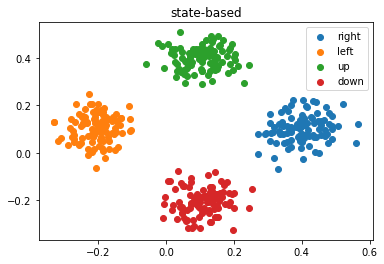

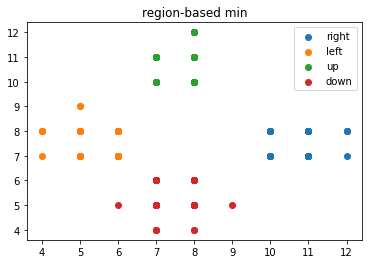

In [39]:
gran =15
initpoint=np.array([0.1,0.1])
numsamples=100
alpha="min"

for version in ("state-based","region-based"):
    samppoints=np.zeros((numsamples,2,4))
    for a in range(4):
        for s in range(numsamples):
            if version=="state-based":
                samppoints[s,:,a]=nextState(initpoint,a)
            else:
                samppoints[s,:,a]=nextState_region(gran,point_to_region(gran,initpoint),a,alpha=alpha)[0]


    for d in range(4):
        plt.scatter(samppoints[:,0,d],samppoints[:,1,d],label=actions[d])
    title=version
    if version=="region-based":
        title+=" " + alpha
    plt.title(title)
    plt.legend()    
    plt.show()

In [40]:
# Learning with different granularities

granularities=(5,10,20,50)
lbda=0.6
numsteps = 20
numepisodes = 5000
alpha=("min","max","sampled")

Qs_for_alpha ={}
for a in alpha:
    Qs=[]
    for g in granularities:
        steps_for_granularity=int(np.floor(numsteps*g/granularities[0]))
        print("granularity ", g, "steps: ", steps_for_granularity)
        Q=Q_learn(g,lbda,steps_for_granularity,numepisodes,a,initstate=None)
        Qs.append(Q)
    Qs_for_alpha[a]=Qs

granularity  5 steps:  20
granularity  10 steps:  40
granularity  20 steps:  80
granularity  50 steps:  200
granularity  5 steps:  20
granularity  10 steps:  40
granularity  20 steps:  80
granularity  50 steps:  200
granularity  5 steps:  20
granularity  10 steps:  40
granularity  20 steps:  80
granularity  50 steps:  200


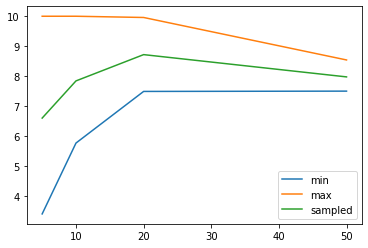

In [50]:
# Learned cost for a given state dependent on granularity

state=np.array((0.9,0.9))
statevals={}

for a in alpha:
    Qs=Qs_for_alpha[a]
    iv=np.zeros(len(Qs))
    for i in range(len(Qs)):
        xr,yr=point_to_region(granularities[i],state)
        iv[i]=(np.min(Qs[i][xr,yr,:]))
    statevals[a]=iv

for a in alpha:
    plt.plot(granularities,statevals[a],label=a)
    
plt.legend()
# plt.xlim(40,100)
# plt.ylim(0.67,0.75)
plt.show()

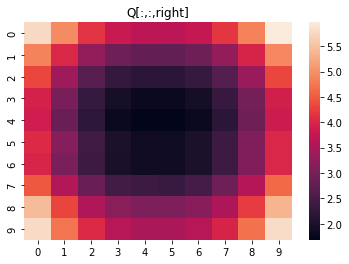

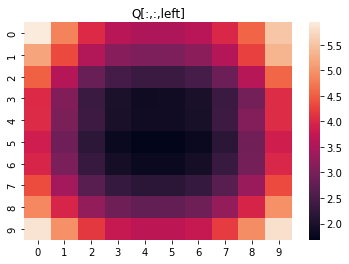

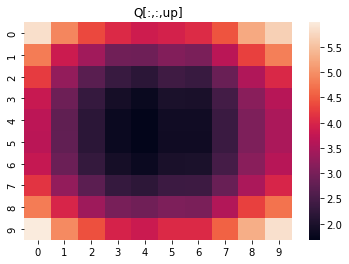

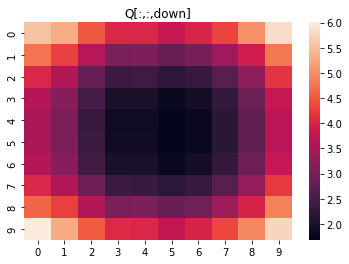

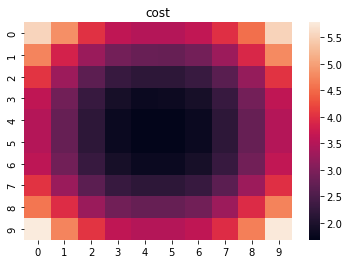

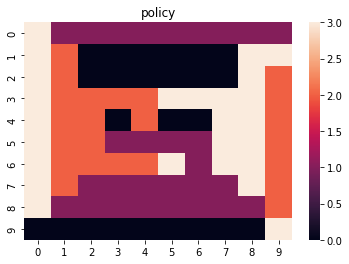

In [55]:
# Heatmaps for Q values, cost values, strategies for selected
# granularity and alpha

gidx=1 # index of granularity in granularities list; not absolute value
alpha="min"
Q=Qs_for_alpha[alpha][gidx]
cost=np.min(Q[:,:,:],axis=2)
policy=np.argmin(Q[:,:,:],axis=2)

for a in range(4):
    sns.heatmap(Q[:,:,a])
    plt.title("Q[:,:,"+actions[a]+"]")
    plt.show()
    
sns.heatmap(cost)
plt.title("cost")
plt.show()

sns.heatmap(policy)
plt.title("policy")
plt.show()